In [1]:
%load_ext autoreload
%autoreload 2
!export TF_CPP_MIN_LOG_LEVEL=0

import h5py
import numpy as np
import torch

from sda.mcs import *
from sda.score import *
from sda.utils import *
import matplotlib.pyplot as plt

from utils import *
chain = make_chain()


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
torch.cuda.is_available()

True

In [19]:
with h5py.File(PATH / 'data/roztest.h5') as f:
    # print(f['x'][1, :29].shape)
    x_star = torch.from_numpy(f['x'][0, :10])

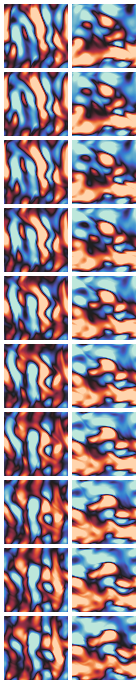

In [20]:
draw(x_star)

(array([  140.,  1275.,  4626., 12542., 18887., 19206., 14062.,  8289.,
         2550.,   343.]),
 array([-3.03571081, -2.45259953, -1.869488  , -1.28637671, -0.70326531,
        -0.1201539 ,  0.46295747,  1.04606891,  1.62918019,  2.21229172,
         2.795403  ]),
 <BarContainer object of 10 artists>)

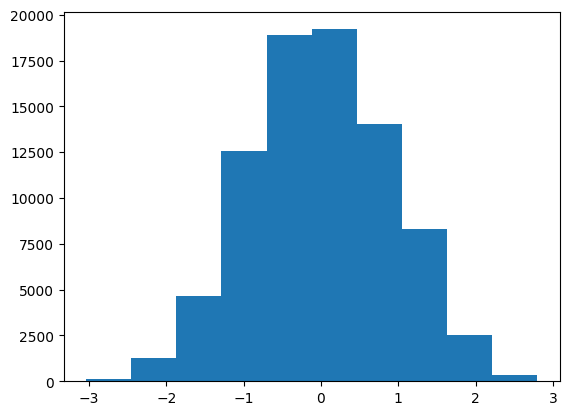

In [21]:
plt.hist(x_star.flatten())

In [22]:
w = KolmogorovFlow.vorticity(x_star)

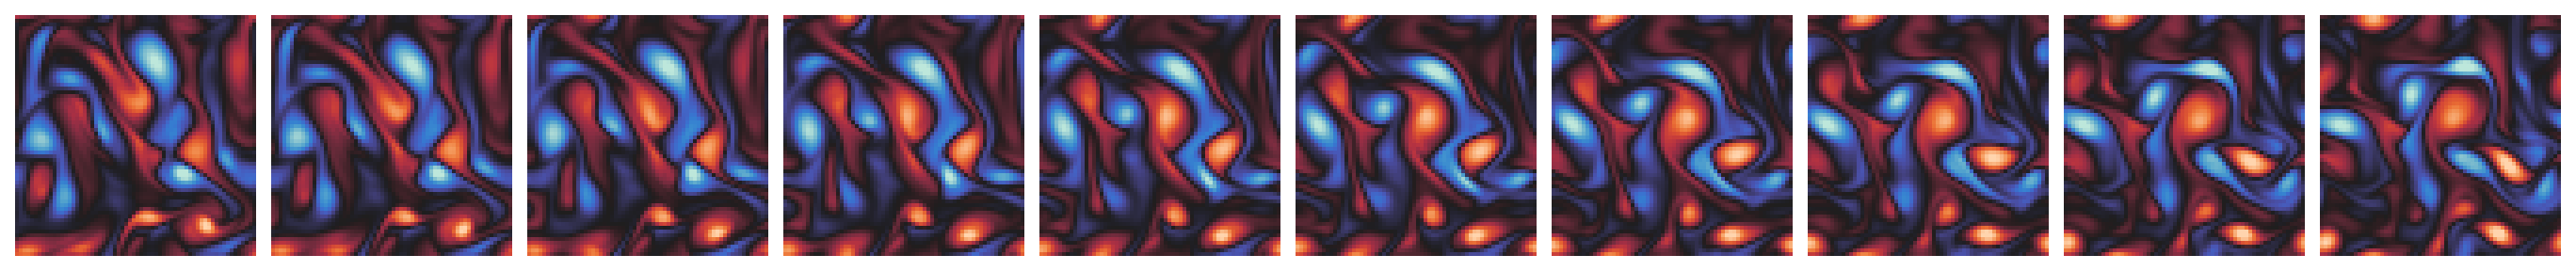

In [25]:
draw(w, zoom =4 )

(array([  268.,  1344.,  3423., 14653., 42527., 40042., 12213.,  3479.,
          703.,   132.]),
 array([-1.66328681, -1.3262434 , -0.98920012, -0.65215677, -0.31511343,
         0.02192992,  0.35897326,  0.69601661,  1.03305995,  1.37010336,
         1.70714664]),
 <BarContainer object of 10 artists>)

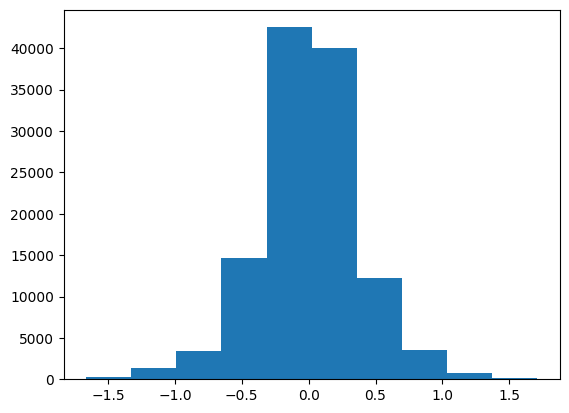

In [10]:
plt.hist(w.flatten())

In [57]:
with h5py.File(PATH / 'data/hf/train.h5') as f:
    print(f['x'][1,-10:].shape)
    x_star = torch.from_numpy(f['x'][0, :10])

(10, 2, 64, 64)


(array([  4161.,  36679., 120037., 206759., 300606., 292261., 209149.,
        105881.,  30165.,   5022.]),
 array([-3.83761477, -3.06358576, -2.28955674, -1.51552773, -0.74149871,
         0.03253031,  0.80655932,  1.58058834,  2.35461736,  3.12864637,
         3.90267539]),
 <BarContainer object of 10 artists>)

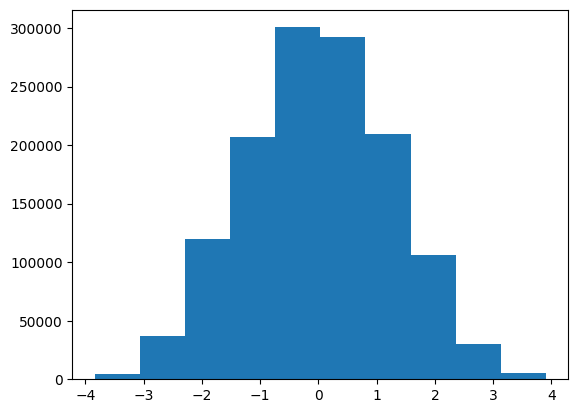

In [52]:
plt.hist(x_star.flatten())

In [59]:
w = KolmogorovFlow.vorticity(x_star)

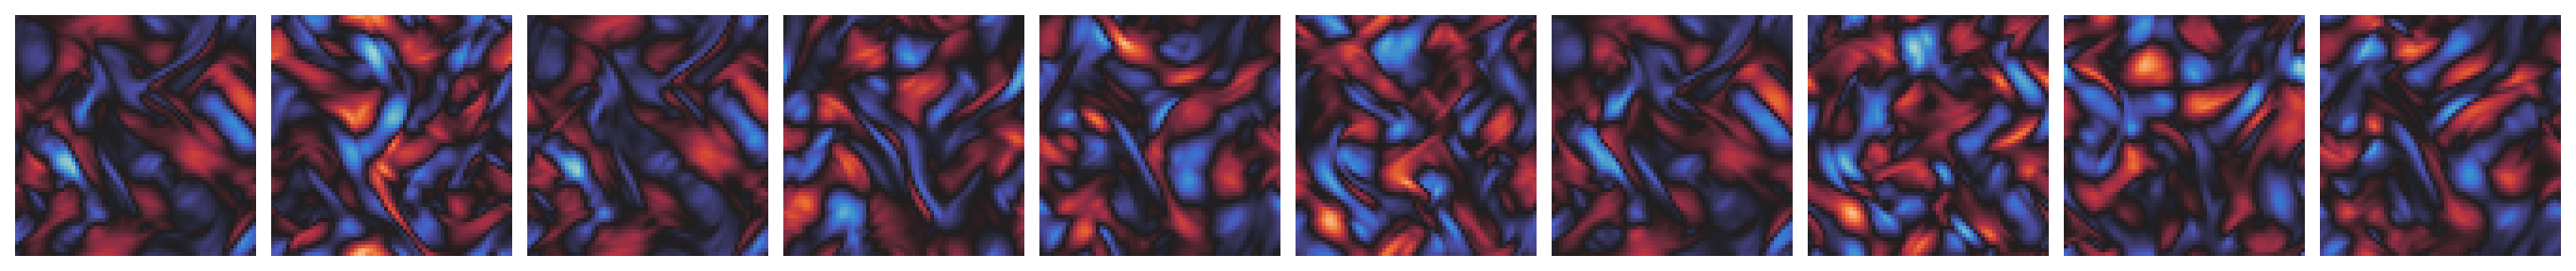

In [60]:

draw( w, zoom =4)


In [3]:
domain_size = 64

## Score network

In [2]:
# score = load_score(PATH / 'runs/glorious-flower-3_zw7vkqm0/state.pth')  # k=1, width=32
# score = load_score(PATH / 'runs/azure-wave-2_9ry6v9ul/state.pth')  # k=1, width=64
# score = load_score(PATH / 'runs/bumbling-monkey-6_3m4uyfe8/state.pth')  # k=1, width=96
# score = load_score(PATH / 'runs/vibrant-ox-15_yvd1kw7v/state.pth')  # k=2, width=96aceful-snowball-8_i6pzpnst
score = load_score(PATH / 'runs/true-armadillo-34_7bryst2v/state.pth')
# score = load_score(PATH / '/home/pmanshausen/sda/experiments/kolmogorov/runs/radiant-dragon-22_twhn1vxq/state.pth')  # k=2, width=96aceful-snowball-8_i6pzpnst

In [40]:
sde=VPSDE(score, shape=(8, 2, domain_size,domain_size)
    # ),
    # shape=(8, 2, domain_size,domain_size),
).cuda()

In [41]:
x = sde.sample((2,), steps=128,corrections=1, tau=0.5).cpu()
# x = x.unflatten(1, (-1, 2))
w = KolmogorovFlow.vorticity(x)



100%|█████████████████████████████████████████████████| 128/128 [00:02<00:00, 57.76it/s]


In [42]:
w = KolmogorovFlow.vorticity(x)



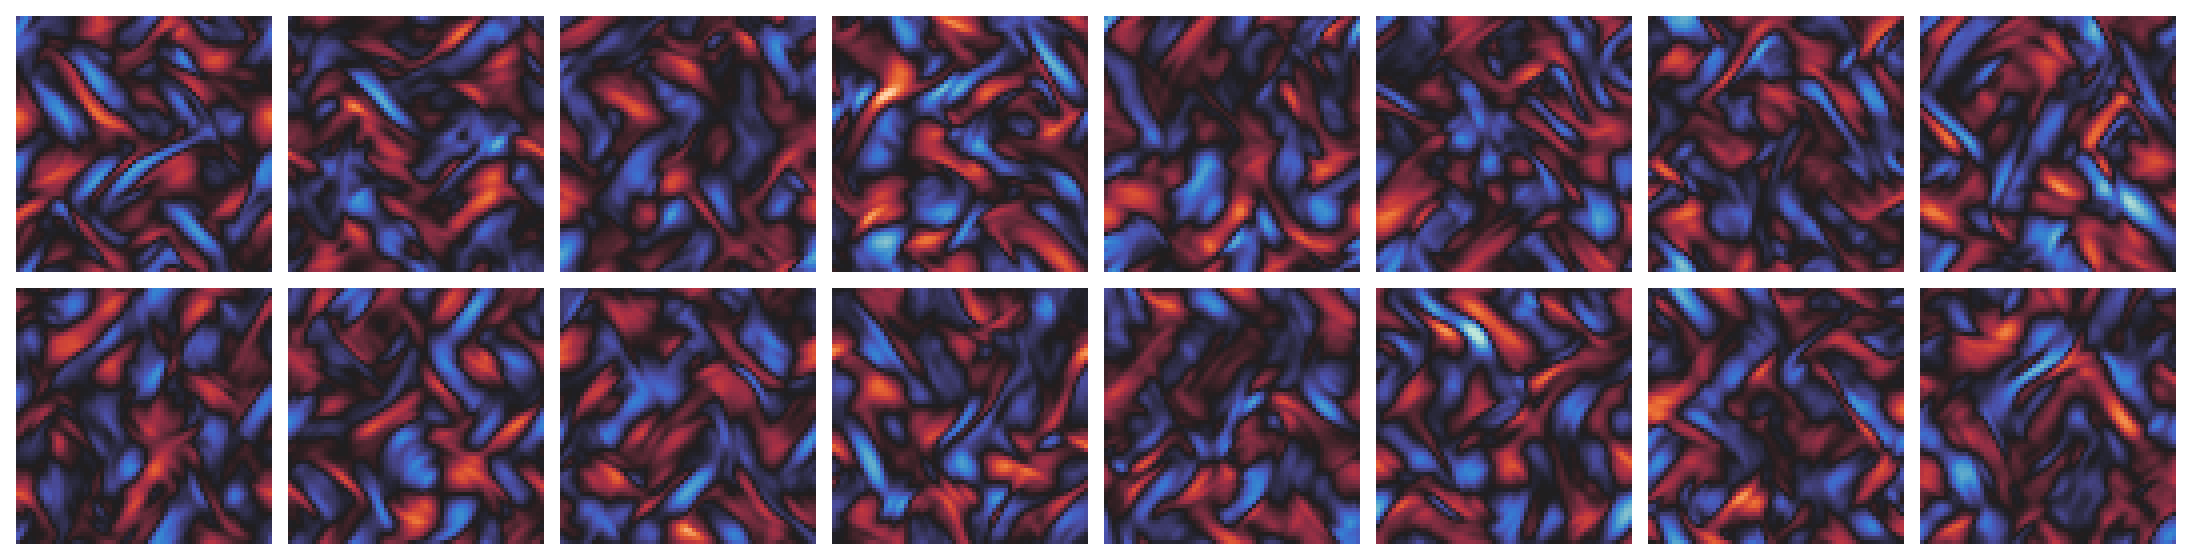

In [43]:
draw( w, zoom =4)

In [51]:
w.shape

torch.Size([2, 8, 256, 256])

## Circle

In [4]:
domain_size = 256
def circle():
    x = torch.linspace(-1, 1, domain_size)
    x = torch.cartesian_prod(x, x)

    dist = x.square().sum(dim=-1).reshape(domain_size,domain_size)
    mask = torch.logical_and(0.4 < dist, dist < 0.6)

    return mask

mask = circle().cuda()

def A(x):
    return chain.vorticity(x[..., -1, :, :, :]) * mask

sde = VPSDE(
    GaussianScore(
        y=0.6 * mask,
        A=A,
        std=0.2,
        sde=VPSDE(score, shape=()),
    ),
    shape=(8, 2, domain_size,domain_size),
).cuda()

In [5]:
x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

# draw(w, zoom=4).save('x_circle.png')


100%|█████████████████████████████████████████████████| 256/256 [01:39<00:00,  2.58it/s]


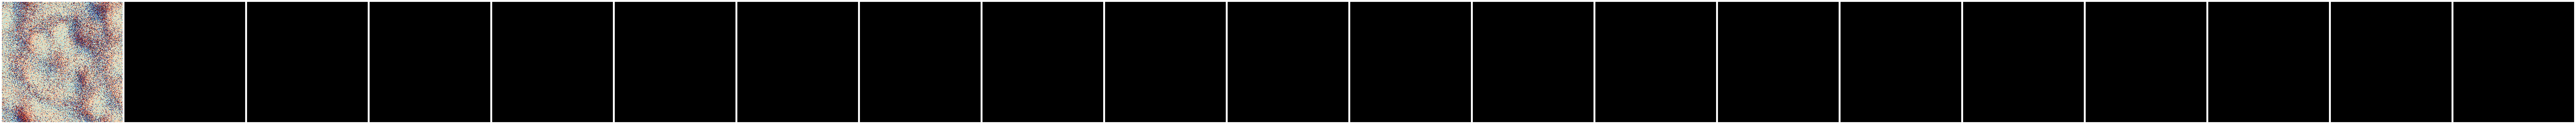

In [14]:
y0 = x[0]#chain.upsample(x[0], 4)
y = chain.trajectory(y0, length=20)
y = torch.cat((y0[None], y))
# y = chain.coarsen(y, 4)

w = chain.vorticity(y)

# draw(w, zoom=4).save('x_circle_sim.png')
draw(w, zoom=4)

## Assimilation

tensor(1.0651)


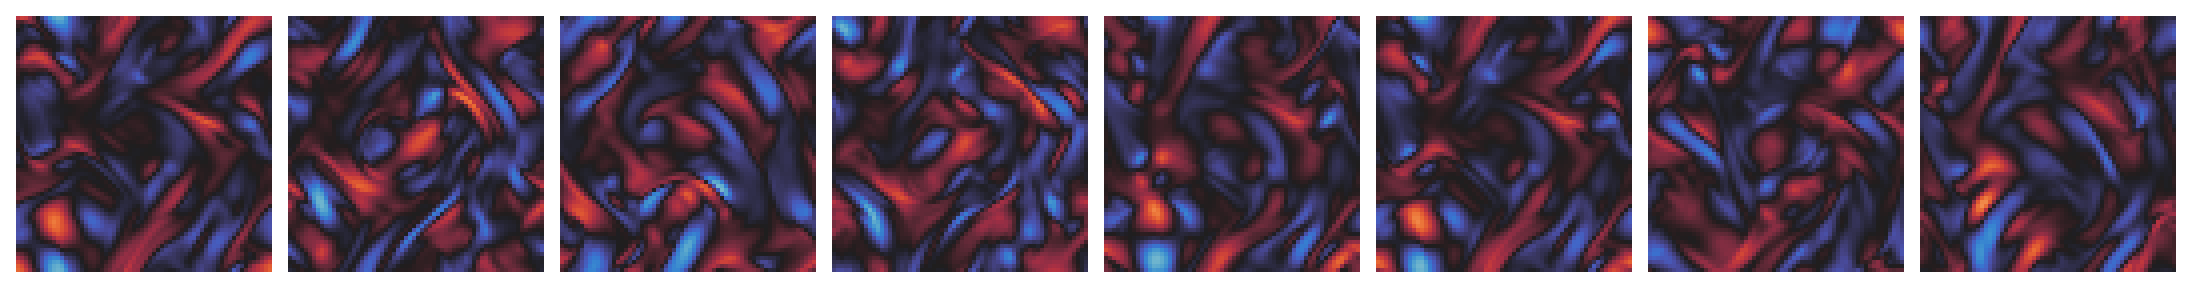

In [5]:
with h5py.File(PATH / 'data/hf/test.h5') as f:
    # print(f['x'][1, :29].shape)
    x_star = torch.from_numpy(f['x'][1, :29])

w = chain.vorticity(x_star[::2])
print(w.max())
# draw(w, zoom=4).save('x_star_assim.png')
draw(w[::2], zoom=4)

tensor(0.0003)
tensor(9.8953e-10)


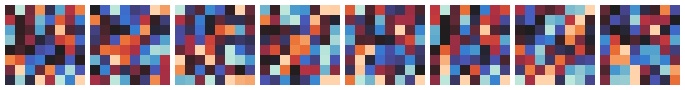

In [6]:
def A(x):
    return chain.coarsen(x[..., ::4, :, :, :], 8) #every fourth frame and coarsened by a factor of eight 

y_star = torch.normal(A(x_star), 0.1)
print(y_star.mean())
w = chain.vorticity(y_star) #/ 2.5
w = chain.upsample(w, 2, mode='nearest')
print(w.mean())
# draw(w, pad=1, zoom=16).save('y_star_assim.png')
draw(w, pad=1, zoom=5)

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.24it/s]


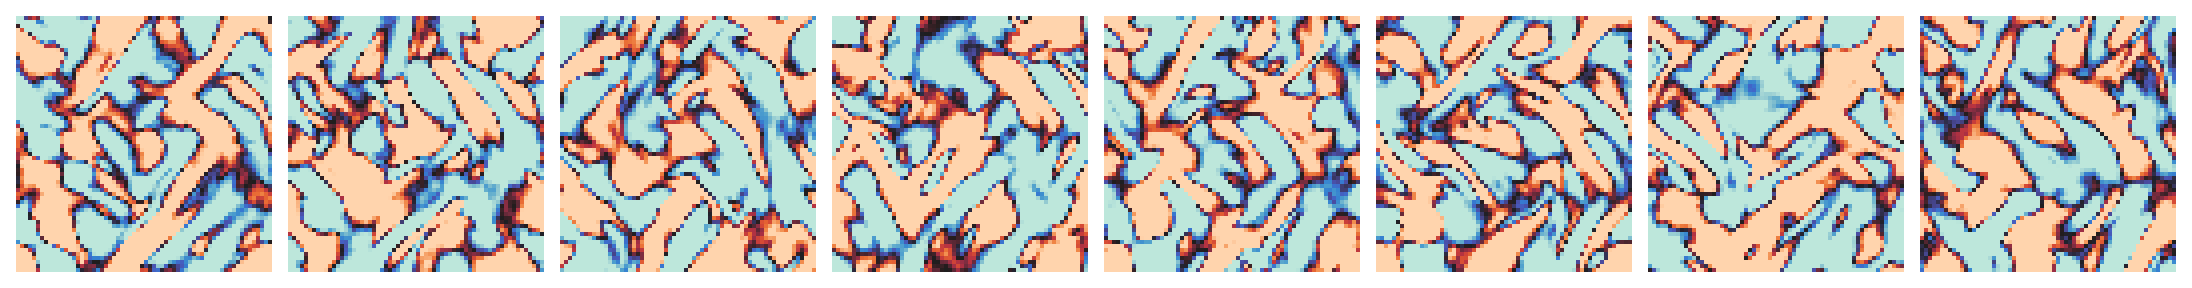

In [7]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x[::4])

# draw(w, zoom=4).save('x_sda_assim.png')
draw( w, zoom=4)

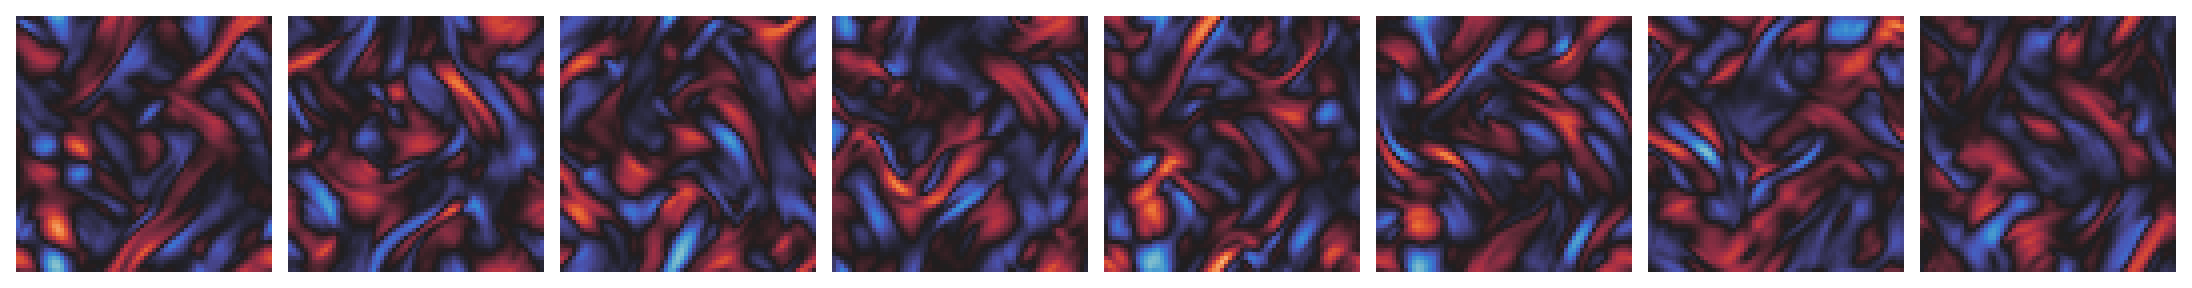

In [8]:
draw( w, zoom=4)

In [9]:
(A(x) - y_star).std()  # should be ≈ 0.1

tensor(0.0980)

100%|█████████████████████████████████████████████████| 256/256 [00:36<00:00,  7.02it/s]


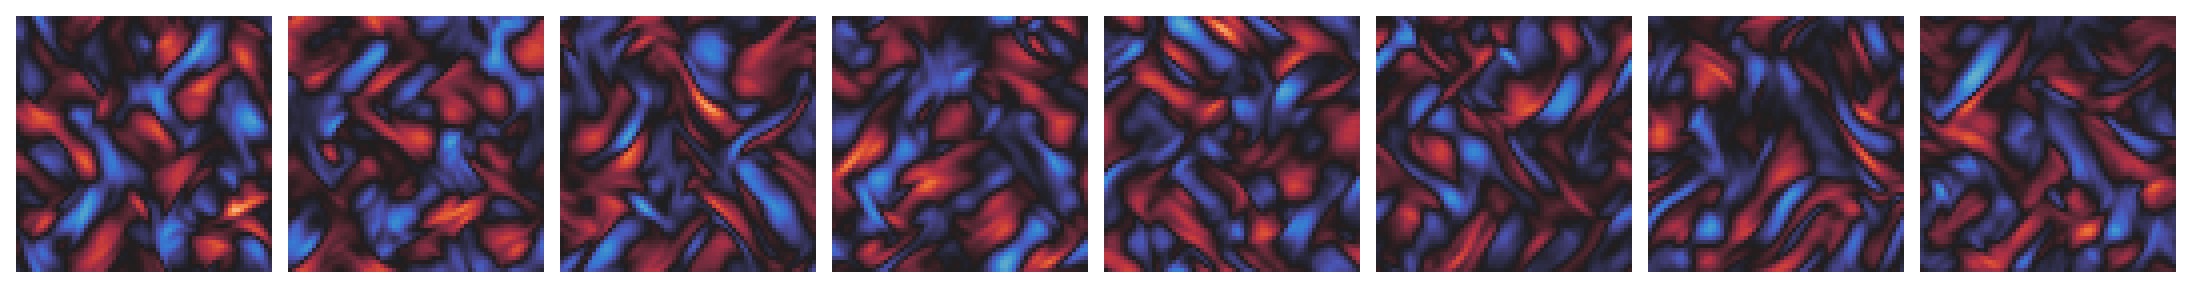

In [10]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x[::4])

# draw(w, zoom=4).save('x_dps_assim.png')
draw(w, zoom=4)

In [11]:
(A(x) - y_star).std()

tensor(0.9165)

## Extrapolation

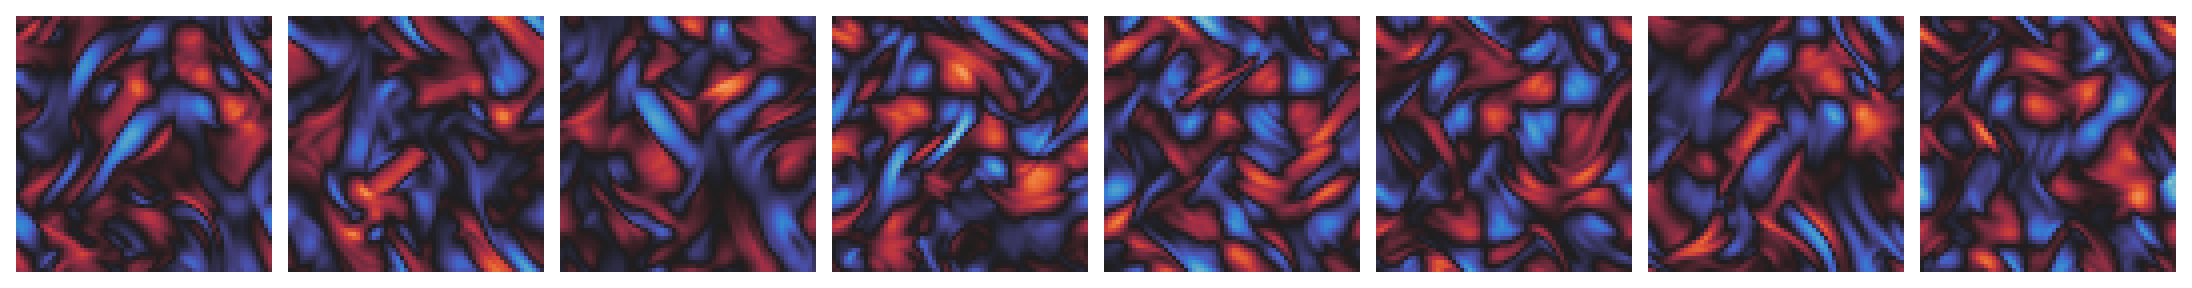

In [12]:
with h5py.File(PATH / 'data/hf/test.h5') as f:
    x_star = torch.from_numpy(f['x'][0, :8])

w = chain.vorticity(x_star)

# draw(w, zoom=4).save('x_star_extra.png')
draw(w, zoom=4)

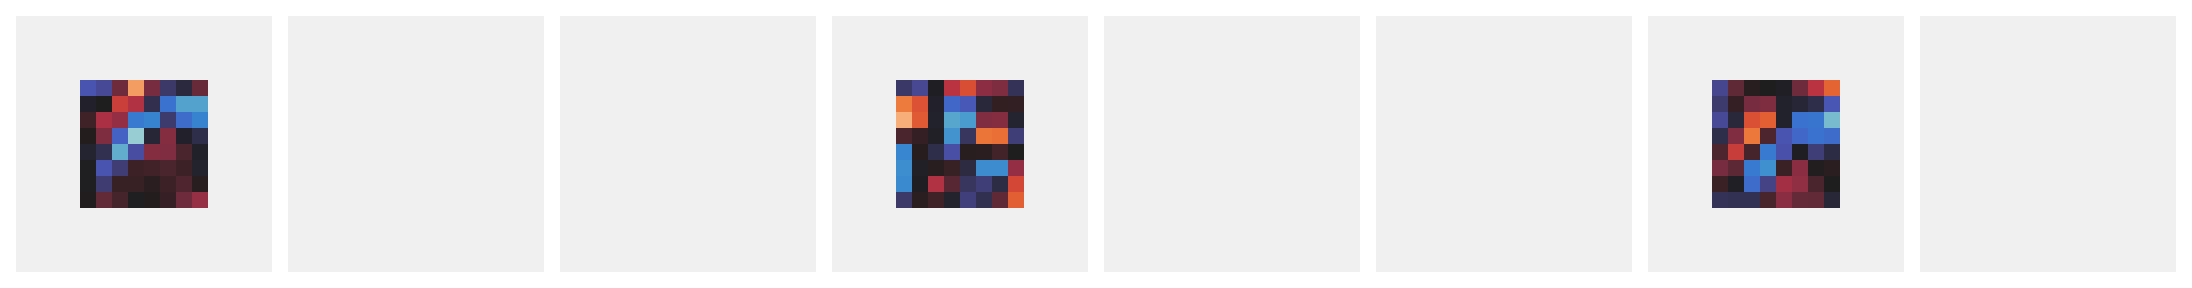

In [13]:
def A(x):
    return chain.coarsen(x, 4)[..., ::3, :, 4:12, 4:12]

y_star = torch.normal(A(x_star), 0.01)

w = chain.vorticity(chain.coarsen(x_star, 4)) / 2

mask = np.zeros((8, 16, 16), dtype=bool)
mask[::3, 4:12, 4:12] = True

# draw(w, mask, pad=1, zoom=16).save('y_star_extra.png')
draw(w, mask, pad=1, zoom=16)

100%|█████████████████████████████████████████████████| 256/256 [00:18<00:00, 13.76it/s]


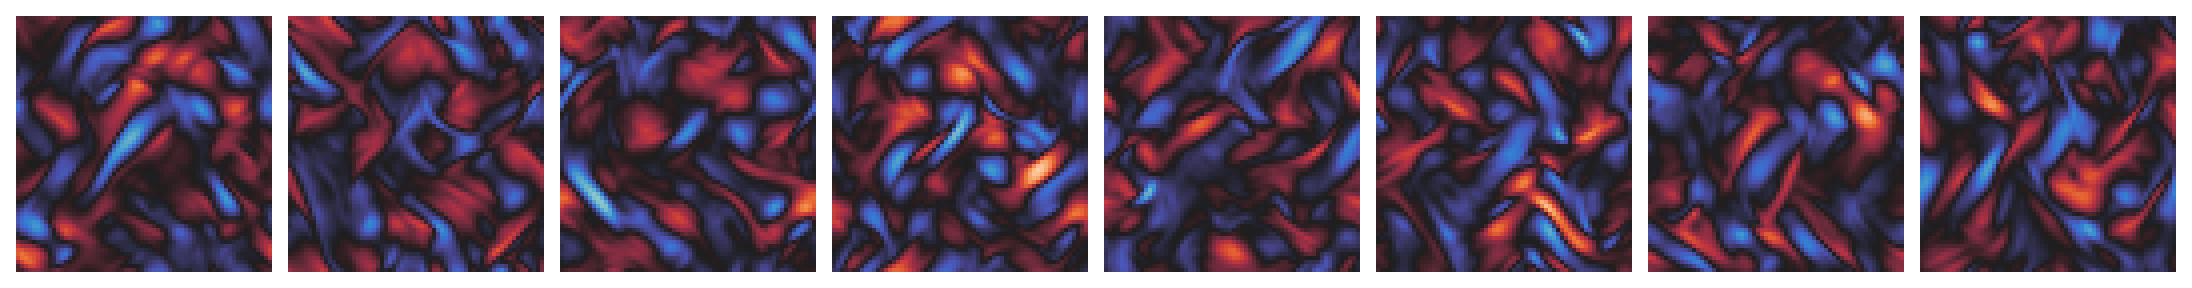

In [14]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.01,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

# draw(w, zoom=4).save('x_sda_extra.png')
draw(w, zoom=4)

In [15]:
(A(x) - y_star).std()  # should be ≈ 0.01

tensor(0.0106)

100%|█████████████████████████████████████████████████| 256/256 [00:18<00:00, 13.81it/s]


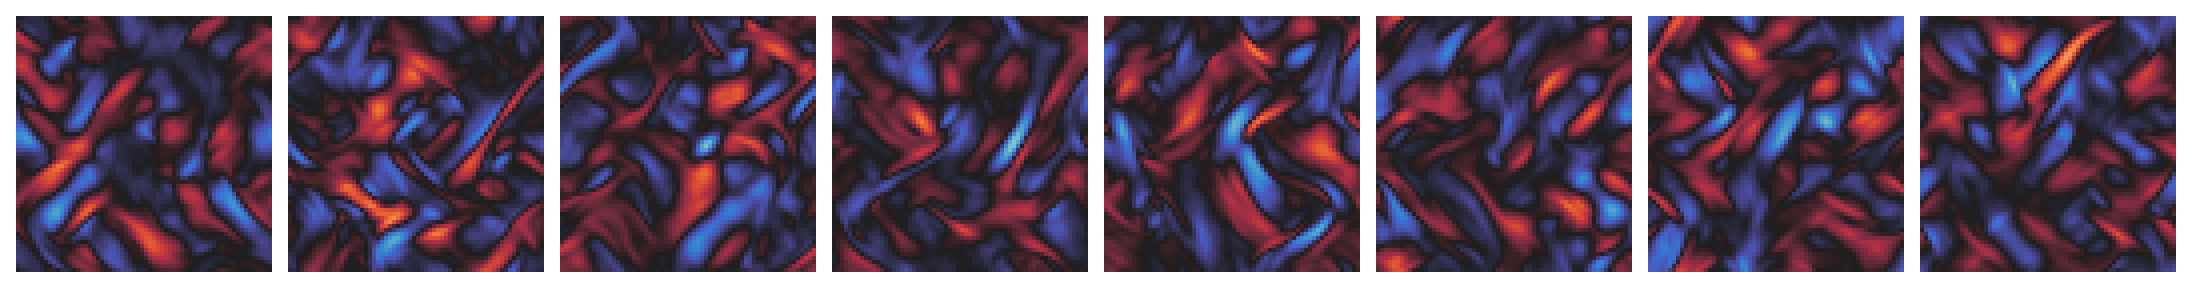

In [16]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

# draw(w, zoom=4).save('x_dps_extra.png')
draw(w, zoom=4)

In [17]:
(A(x) - y_star).std()

tensor(0.8577)

## Non-linear observation process

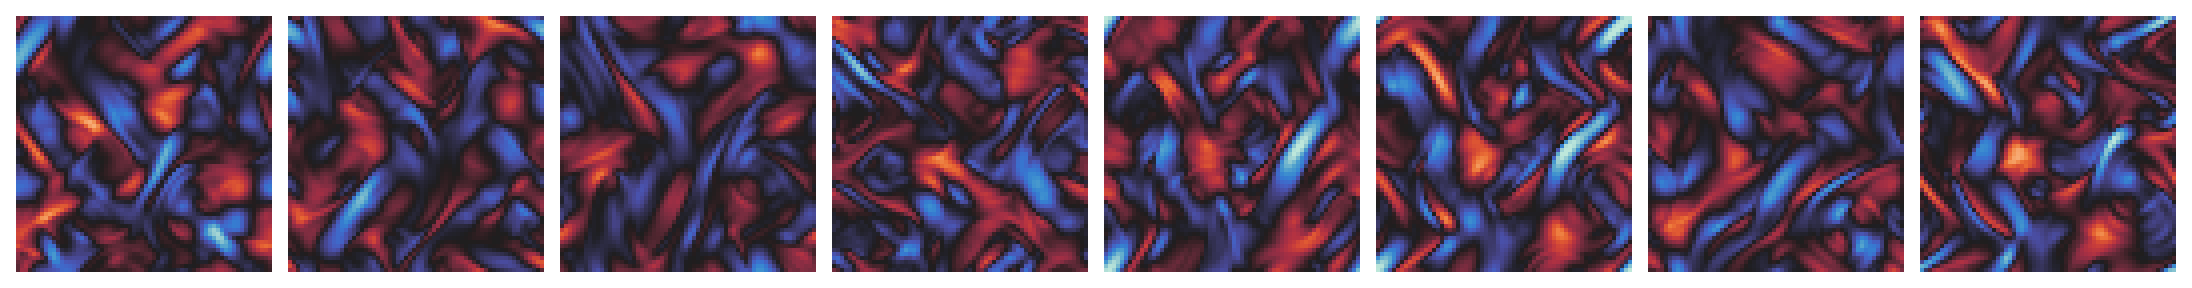

In [19]:
with h5py.File(PATH / 'data/hf/test.h5') as f:
    x_star = torch.from_numpy(f['x'][2, :8])

w = chain.vorticity(x_star)

# draw(w, zoom=4).save('x_star_saturation.png')
draw(w, zoom=4)

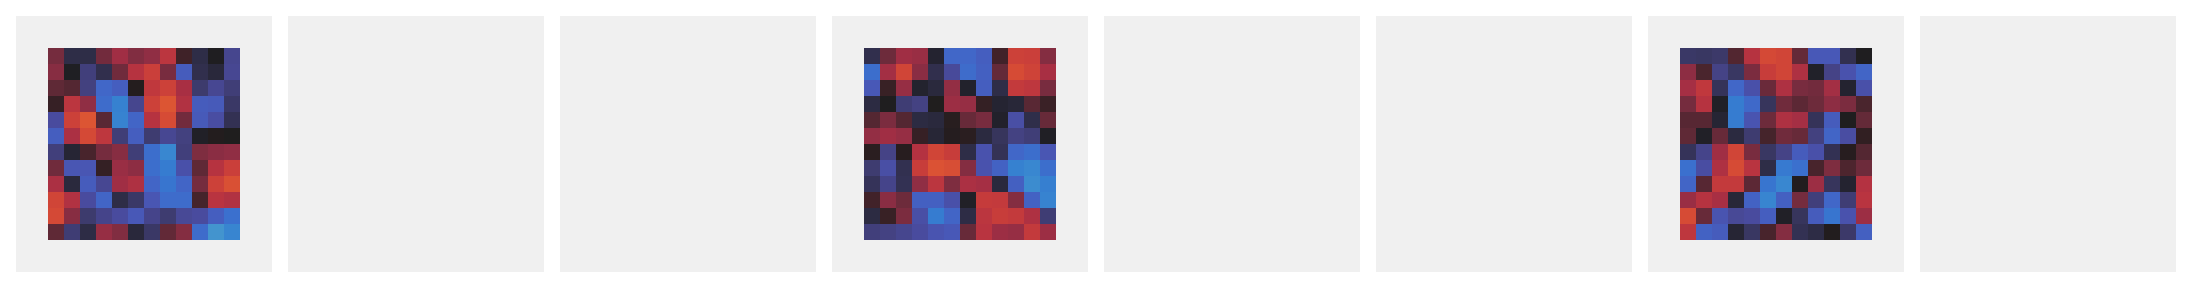

In [22]:
scaling =1 
def A(x):
    x = chain.coarsen(x[..., ::3, :, :, :], 4)
    w = chain.vorticity(x)
    w = w / (1 + abs(w))

    return w[..., 2*scaling:14*scaling, 2*scaling:14*scaling]

y_star = torch.normal(A(x_star), 0.05)

w = chain.vorticity(chain.coarsen(x_star, 4))
w = w / (1 + abs(w))

mask = np.zeros((8, 16*scaling, 16*scaling), dtype=bool)
mask[::3, 2*scaling:14*scaling, 2*scaling:14*scaling] = True

# draw(w, mask, pad=1, zoom=16).save('y_star_saturation.png')
draw(w, mask, pad=1, zoom=16)

100%|█████████████████████████████████████████████████| 512/512 [01:56<00:00,  4.39it/s]


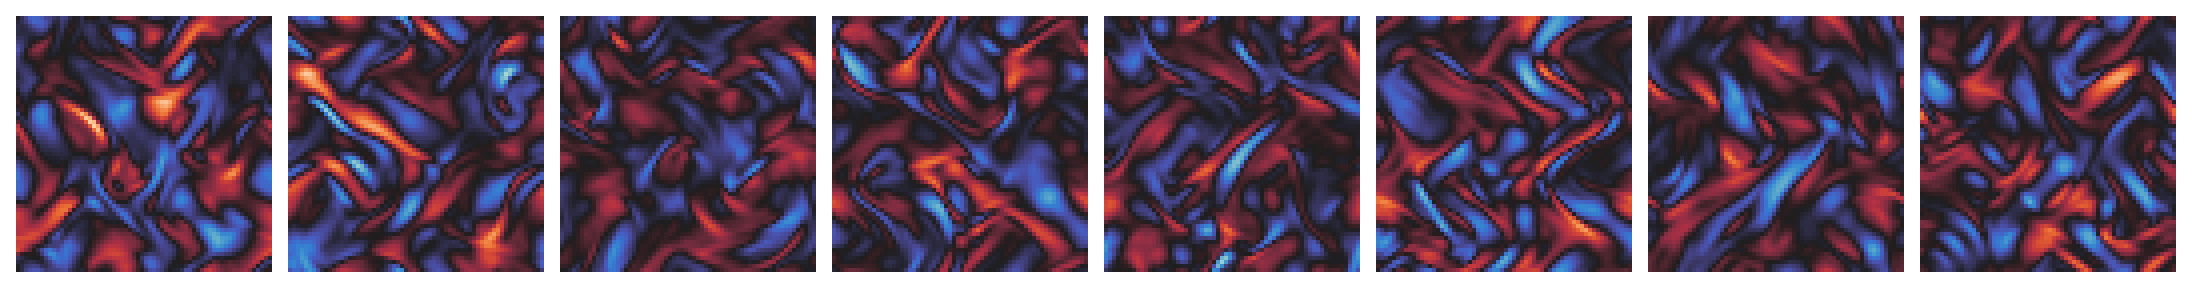

In [23]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.05,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=512, corrections=5, tau=0.5).cpu()
w = chain.vorticity(x)

# draw(w, zoom=4).save('x_sda_saturation.png')
draw(w, zoom=4)

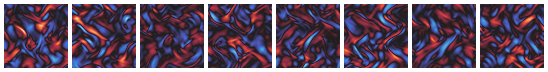

In [24]:
draw(w, zoom=1)

In [25]:
(A(x) - y_star).std()

tensor(0.0570)

100%|██████████| 512/512 [00:34<00:00, 14.83it/s]


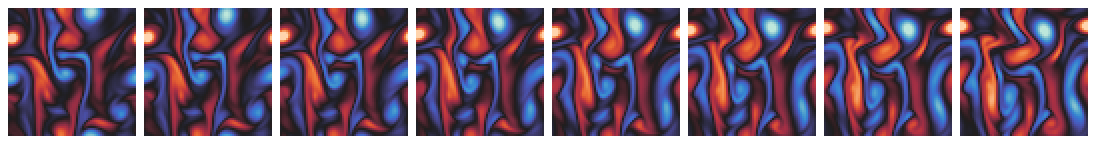

In [22]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=512, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_saturation.png')
draw(w, zoom=4)

In [23]:
(A(x) - y_star).std()

tensor(0.5483)

## Subsampling

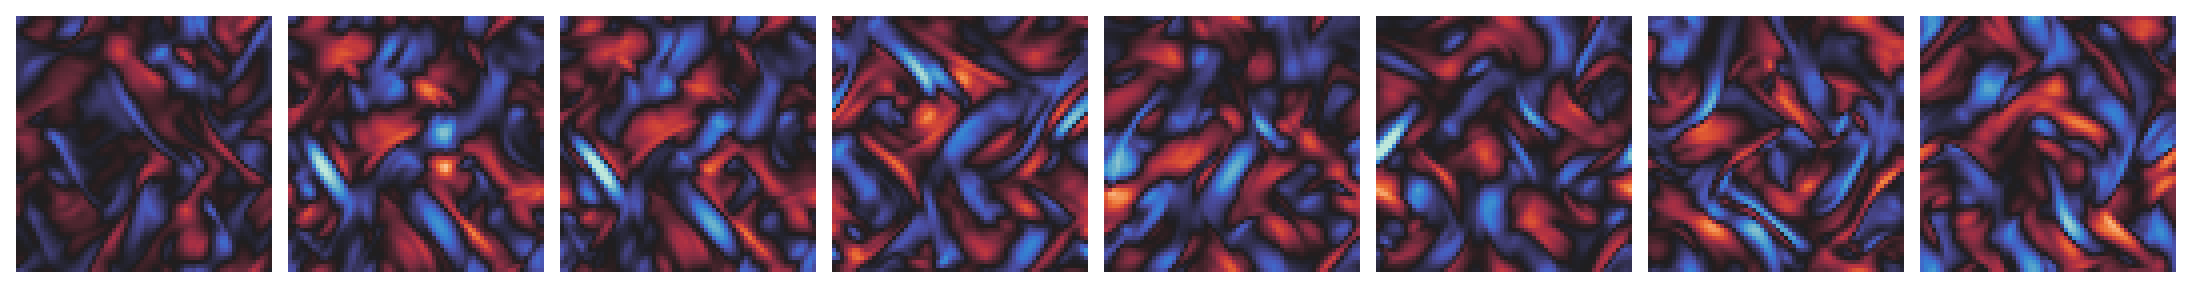

In [27]:
with h5py.File(PATH / 'data/hf/test.h5') as f:
    x_star = torch.from_numpy(f['x'][3, -8:])

w = chain.vorticity(x_star)

# draw(w, zoom=4).save('x_star_sub.png')
draw( w, zoom=4)

In [28]:
w.shape

torch.Size([8, 64, 64])

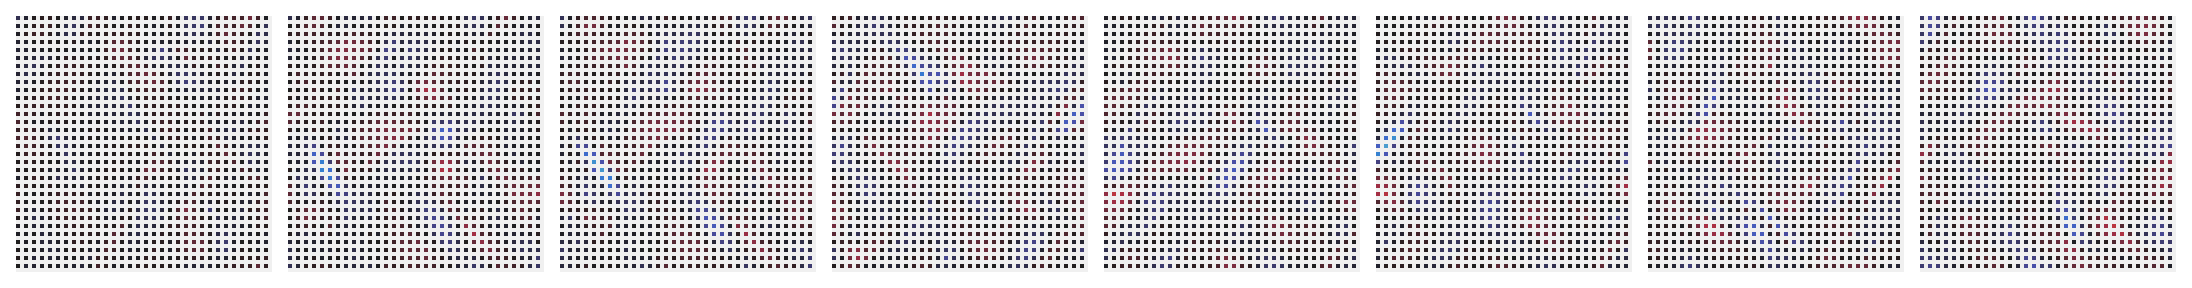

In [29]:
def A(x):
    return x[..., ::2, ::2]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64,64), dtype=bool)
mask[:, ::2, ::2] = True

# draw(w, mask, zoom=4).save('y_star_sub_2.png')
draw(w, mask, zoom=4)

100%|█████████████████████████████████████████████████| 256/256 [00:18<00:00, 13.87it/s]


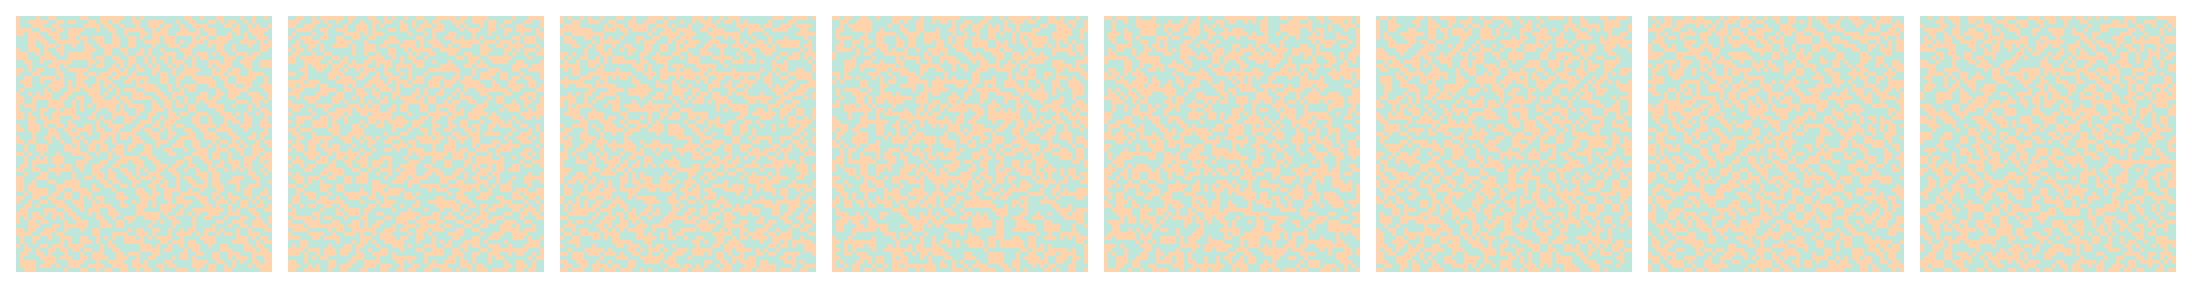

In [30]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

# draw(w, zoom=4).save('x_sda_sub_2.png')
draw(w, zoom=4)

100%|█████████████████████████████████████████████████| 256/256 [00:18<00:00, 13.92it/s]


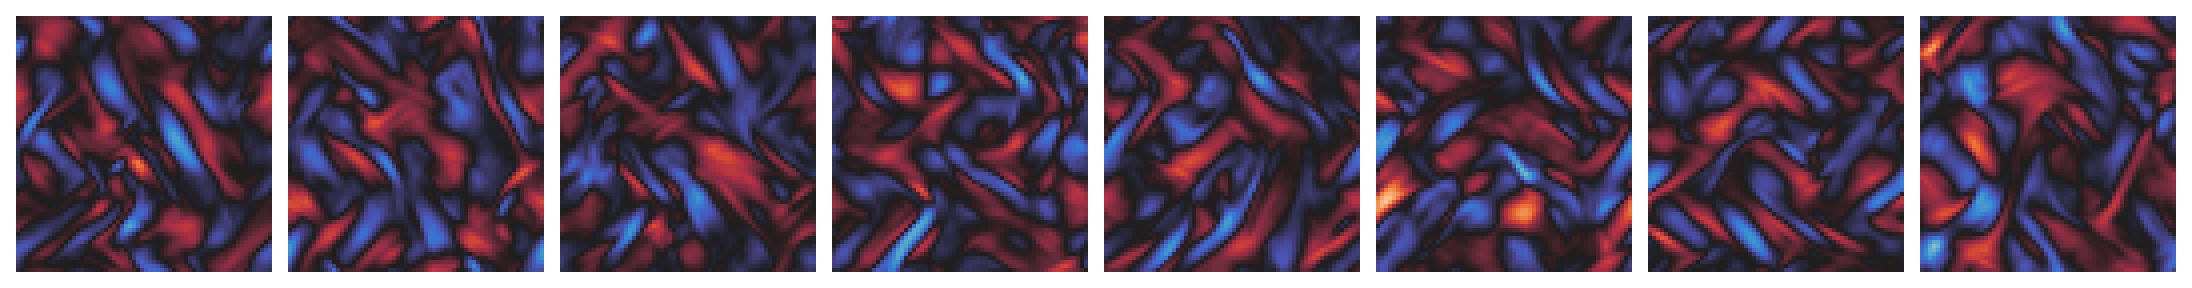

In [31]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

# draw(w, zoom=4).save('x_dps_sub_2.png')
draw(w, zoom=4)

In [35]:
y_star.shape

torch.Size([8, 2, 16, 16])

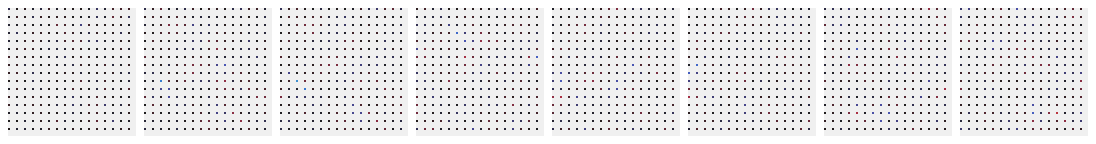

In [34]:
def A(x):
    return x[..., ::4, ::4]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::4, ::4] = True

# draw(w, mask, zoom=4).save('y_star_sub_4.png')
draw(w, mask, zoom=2)

100%|█████████████████████████████████████████████████| 256/256 [00:19<00:00, 13.23it/s]


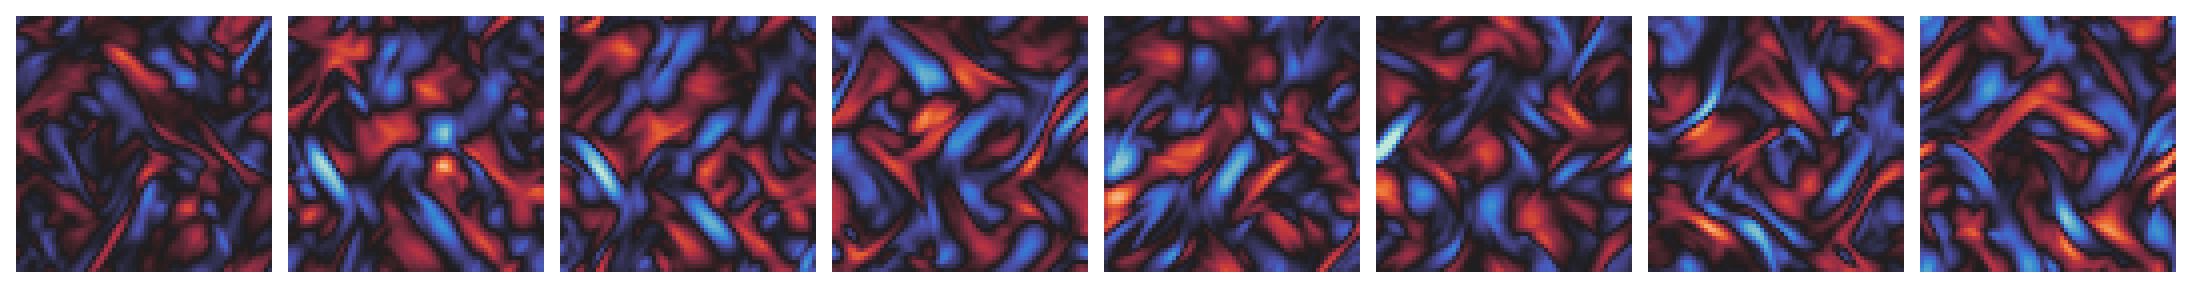

In [37]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

# draw(w, zoom=4).save('x_sda_sub_4.png')
draw(w, zoom=4)

100%|█████████████████████████████████████████████████| 256/256 [00:18<00:00, 13.95it/s]


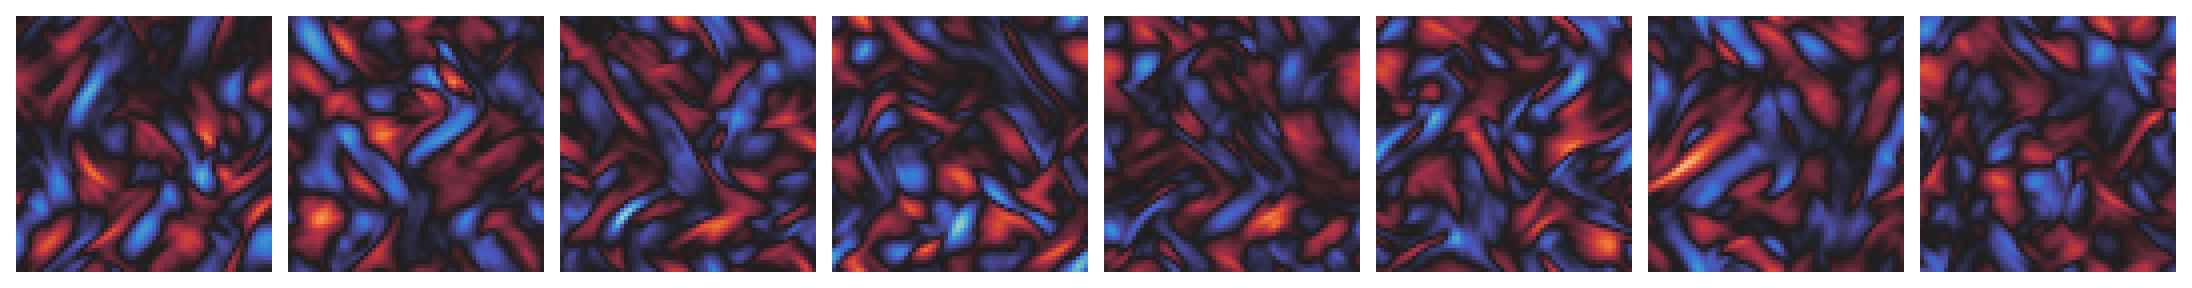

In [38]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

# draw(w, zoom=4).save('x_dps_sub_4.png')
draw(w, zoom=4)

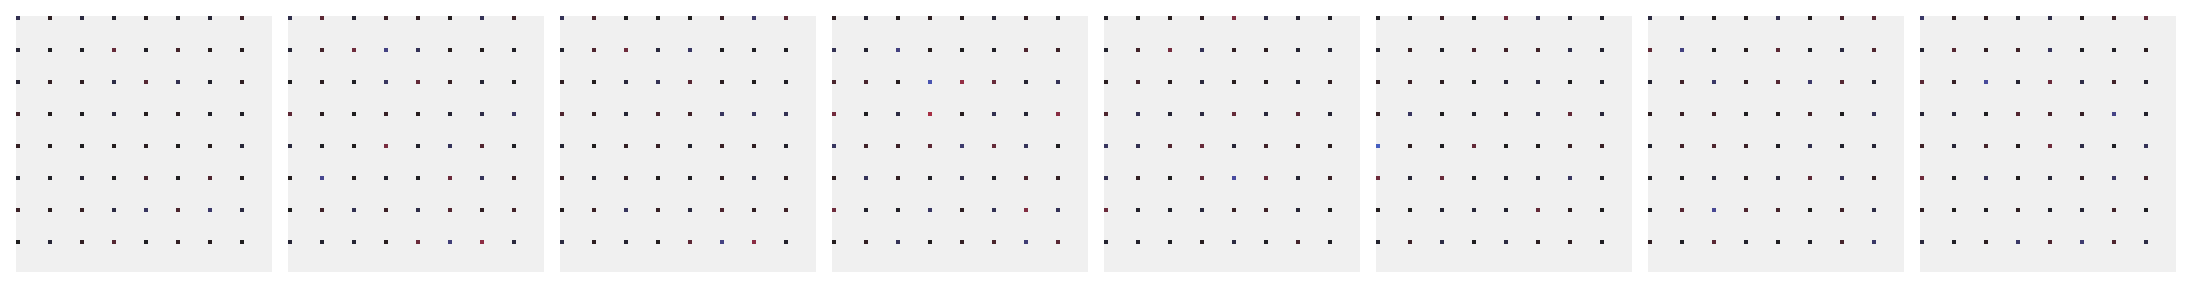

In [39]:
def A(x):
    return x[..., ::8, ::8]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::8, ::8] = True

# draw(w, mask, zoom=4).save('y_star_sub_8.png')
draw(w, mask, zoom=4)

100%|█████████████████████████████████████████████████| 256/256 [00:18<00:00, 13.95it/s]


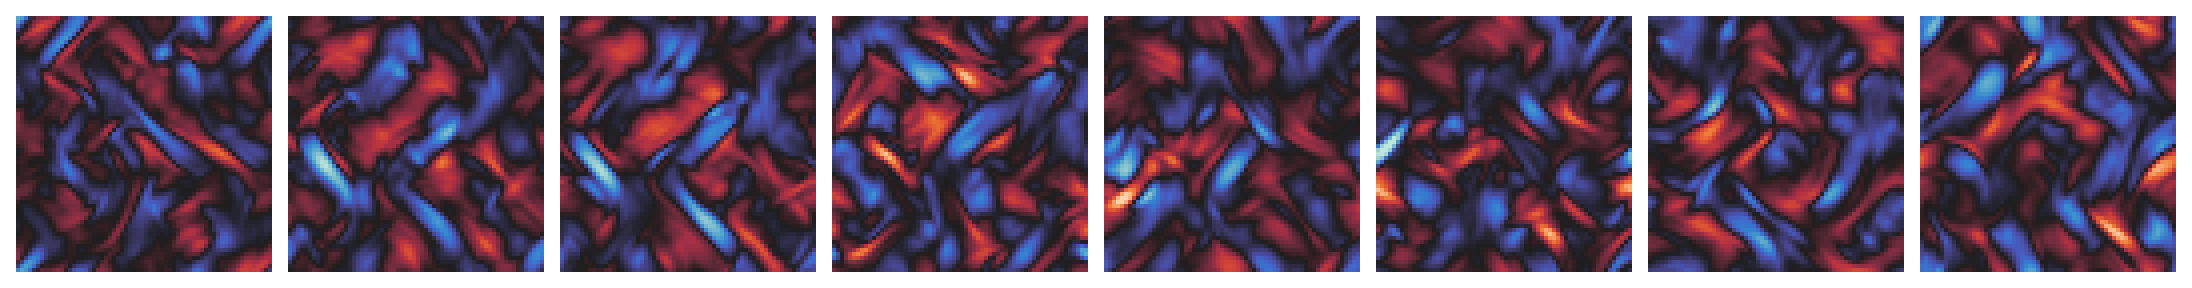

In [40]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

# draw(w, zoom=4).save('x_sda_sub_8.png')
draw(w, zoom=4)

100%|██████████| 256/256 [00:16<00:00, 15.10it/s]


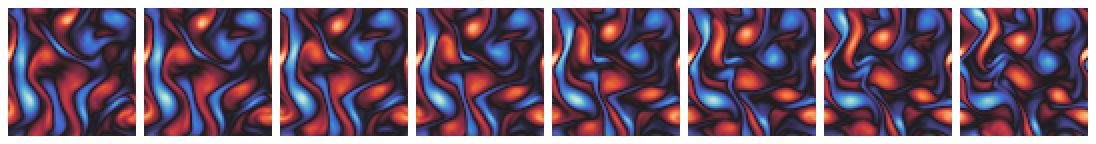

In [33]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_sub_8.png')
draw(w, zoom=4)

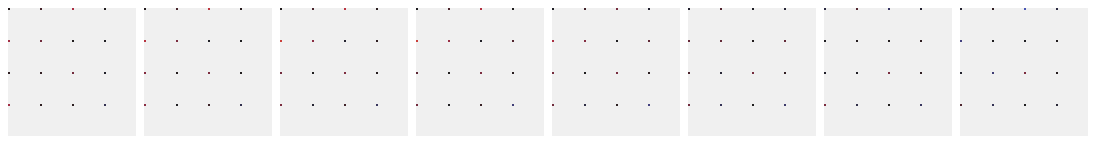

In [34]:
def A(x):
    return x[..., ::16, ::16]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::16, ::16] = True

draw(w, mask, zoom=4).save('y_star_sub_16.png')
draw(w, mask, zoom=4)

100%|██████████| 256/256 [00:16<00:00, 15.26it/s]


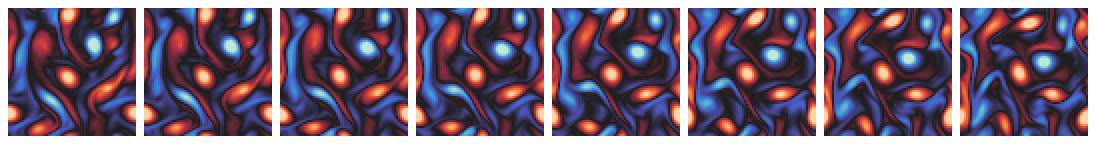

In [35]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_16.png')
draw(w, zoom=4)

100%|██████████| 256/256 [00:16<00:00, 15.27it/s]


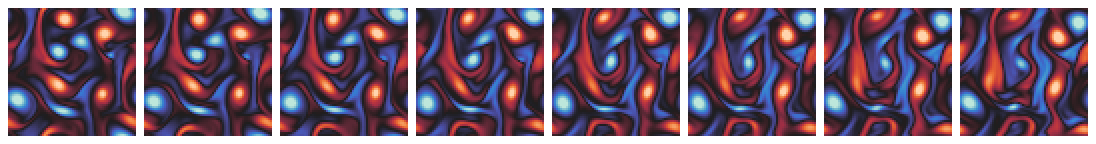

In [36]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_sub_16.png')
draw(w, zoom=4)

## Loop

100%|██████████| 256/256 [06:19<00:00,  1.48s/it]


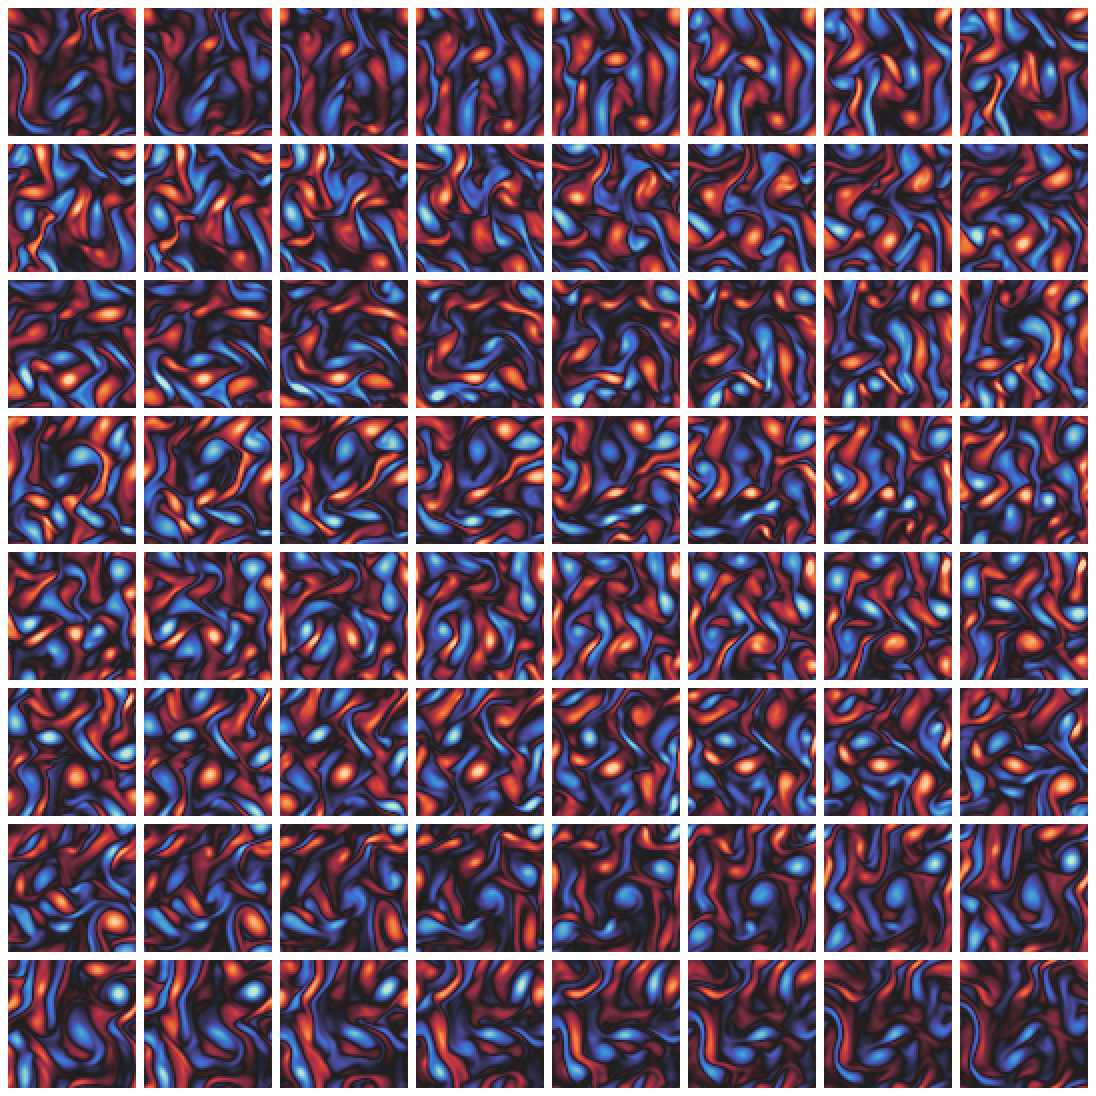

In [37]:
sde = VPSDE(
    GaussianScore(
        torch.zeros(2, 64, 64),
        A=lambda x: x[:, 0] - x[:, -1],
        std=0.01,
        sde=VPSDE(score, shape=()),
        gamma=0.1,
    ),
    shape=(127, 2, 64, 64),
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x[::2])

draw(w.reshape(8, 8, 64, 64), zoom=4).save('x_loop.png')
draw(w.reshape(8, 8, 64, 64), zoom=4)